In [1]:
import os
import random
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:

pth = "C:\\Users\\matfl\\Music\\iTunes\\iTunes Media\\Music\\"
os.listdir(pth+"Beach House")

['7',
 'Beach House',
 'Bloom',
 'Depression Cherry',
 'Devotion',
 'Teen Dream',
 'Thank Your Lucky Stars']

In [3]:
os.listdir(pth+"Los Campesinos!")

['A Good Night For A Fistfight (Live At Is',
 'Hello Sadness',
 'Hold on Now, Youngster.._',
 'NO BLUES',
 'Romance Is Boring',
 'Sick Scenes',
 'Sticking Fingers Into Sockets',
 'Tiptoe Through The True Bits',
 'Too Many Flesh Suppers (Single)',
 'We Are  Beautiful, We Are Doomed Disc 1',
 'We Throw Parties, You Throw Knives']

Okay, now that I have looked at the files - let me loop through and see how many of each file type we have.

In [4]:
out = []
for i in os.listdir(pth+"Los Campesinos!"):
    lv = os.listdir(pth+"Los Campesinos!\\"+i)
    ft = [i[-4:] for i in lv]
    out.extend(ft)

In [5]:
from collections import Counter
Counter(out)

Counter({'.mp3': 49, '.m4a': 45})

In [6]:
out = []
for i in os.listdir(pth+"Beach House"):
    lv = os.listdir(pth+"Beach House\\"+i)
    ft = [i[-4:] for i in lv]
    out.extend(ft)
    
Counter(out)

Counter({'.m4a': 42, '.mp3': 27})

Okay, so I will need to handle both m4a and mp3 files.  I'll want to make sure I build a function that can load both, on top of the libraries, and then also do test train split at a song level.  From there i can build 30 second clips of each.

In [7]:
import librosa
from audio2numpy import open_audio
from pydub import AudioSegment
import sounddevice as sd

In [8]:
example_mp3 = pth+"Beach House\\Thank Your Lucky Stars\\"+'1-01 Majorette.mp3'

example_m4a = pth+"Los Campesinos!\\Hello Sadness\\01 By Your Hand.m4a"

The mfcc we will use later uses one channel, so i'll keep the stereo version but make a one channel version.

In [9]:
def general_musicimport_stereo(pathinput):
    if pathinput[-4:] == ".m4a":
        seg = AudioSegment.from_file(pathinput)
        sampling_rate = seg.frame_rate
        channel_sounds = seg.split_to_mono()
        samples_stereo = [s.get_array_of_samples() for s in channel_sounds]
        samples_stereo = np.asarray(samples_stereo).transpose()
        #may need to make sure this is right
        return samples_stereo, sampling_rate
    elif pathinput[-4:] == ".mp3":
        #open audio from audio 2 numpy
        signal, sampling_rate = open_audio(pathinput)
        return signal, sampling_rate
    else:
        print("This filetype isn't one that this was built for, it is of filetype" + pathinput[-4:])

Below also added a part that sets frame rate as 44100.

In [10]:
def general_musicimport(pathinput):
    seg = AudioSegment.from_file(pathinput).set_channels(1).set_frame_rate(44100)
    sampling_rate = seg.frame_rate
    samples_stereo = seg.get_array_of_samples()
    samples_stereo = np.asarray(samples_stereo).transpose()
    #may need to make sure this is right
    return samples_stereo, sampling_rate


In [11]:
byh, srate = general_musicimport(example_m4a)

In [12]:
sd.play(byh, srate)

In [13]:
byh.shape

(10951616,)

In [14]:
sd.stop()

In [199]:
mjr, srate = general_musicimport(example_mp3)

In [200]:
sd.play(mjr, srate)

In [201]:
mjr.shape

(10617516,)

Okay, so this generally works!  How slow is it...

In [202]:
#for m4a
%timeit byh, srate = general_musicimport(example_m4a)

869 ms ± 9.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [203]:
#for mp3
%timeit mjr, srate = general_musicimport(example_mp3)

996 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Okay, not great, but for these purposes fine.  Interestingly m4a seemed to be a lot slower with audio2numpy, but pydub is better.

Next step is moving on to a test train split, before taking 30 second samples randomly from songs.

In [15]:
#a function to take all songs of an artist and select
def allsongs(artist):
    bhlist = []
    for i in os.listdir(pth+artist):
        lv = os.listdir(pth+artist+"\\"+i)
        lv = [pth+artist+"\\"+i+"\\"+sname for sname in lv]
        bhlist.extend(lv)
    return bhlist

In [16]:
from sklearn.model_selection import train_test_split

bh_list = allsongs("Beach House")
lc_list = allsongs("Los Campesinos!")

In [17]:
BHTrain, BHTest = train_test_split(bh_list, test_size=0.2, random_state=4)
LCTrain, LCTest = train_test_split(lc_list, test_size=0.2, random_state=4)

In [18]:
Train = BHTrain + LCTrain
Test = BHTest + LCTest

In [19]:
random.shuffle(Train)
random.shuffle(Test)

Now that test and train are selected, let's load them in.  The plan will be:

make a function that loads in everything in the list.

From there, make a function that randomly selects a song, and makes a random 30 second sample of it.

In [20]:
re.split(r'/|\\', r"C:\Users\matfl\Music\iTunes\iTunes Media\Music\Los Campesinos!\NO BLUES\1-04 Cemetery Gaits.mp3")

['C:',
 'Users',
 'matfl',
 'Music',
 'iTunes',
 'iTunes Media',
 'Music',
 'Los Campesinos!',
 'NO BLUES',
 '1-04 Cemetery Gaits.mp3']

In [21]:
def loadsonglist(songlist):
    retlist = []
    for i in songlist:
        print(i)
        signal, sr = general_musicimport(i)
        artist = re.split(r'/|\\', i)[7]  
        #will always be in position 7 for me in music folder, dont need to deal with raw since it is a variable
        retlist.append([signal, sr, artist])
    return retlist

In [22]:
Train_songs = loadsonglist(Train)

C:\Users\matfl\Music\iTunes\iTunes Media\Music\Los Campesinos!\Hold on Now, Youngster.._\04 Drop It Doe Eyes.m4a
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Los Campesinos!\Romance Is Boring\10 Heart Swells   100-1.mp3
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Los Campesinos!\Hello Sadness\09 Baby I Got The Death Rattle.m4a
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Los Campesinos!\Hello Sadness\04 Life Is A Long Time.m4a
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Beach House\Beach House\1-01 Saltwater.mp3
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Beach House\Devotion\02 You Came To Me.m4a
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Beach House\Bloom\09 On The Sea.m4a
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Beach House\7\11 Last Ride.m4a
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Beach House\Devotion\04 Turtle Island.m4a
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Los Campesinos!\NO BLUES\1-02 What Death Leaves Behind.mp3
C:\Users\matfl\Music\iTune

C:\Users\matfl\Music\iTunes\iTunes Media\Music\Beach House\7\07 Black Car.m4a
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Beach House\7\04 L'Inconnue.m4a
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Los Campesinos!\A Good Night For A Fistfight (Live At Is\1-01 Ways To Make It Through The Wal.mp3
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Los Campesinos!\Sick Scenes\11 Hung Empty.m4a
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Los Campesinos!\Hello Sadness\01 By Your Hand.m4a
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Los Campesinos!\We Are  Beautiful, We Are Doomed Disc 1\07 The End of the Asterisk.m4a
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Beach House\Depression Cherry\07 Wildflower.mp3
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Los Campesinos!\Hello Sadness\07 The Black Bird, The Dark Slope.m4a
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Beach House\Devotion\08 Some Things Last a Long Time.m4a
C:\Users\matfl\Music\iTunes\iTunes Media\Music\Los Campesino

Going to hold off on loading test for now...no real reason to put it in memory.  Also, do any of these have any different frequencies?

In [23]:
freqs = [i[1] for i in Train_songs]

In [24]:
Counter(freqs)

Counter({44100: 130})

Okay, a few, so i'll hold on.  Makes this more generalizable anyways.  This function takes a song and makes a 30 second sample:

(NOTE - they no longer all have diff frequencies but I will still keep this for now).

In [25]:
Train_songs[0][0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

Going to set the seed before I take more samples.

In [26]:
random.seed(12345)

In [27]:
def thirty_sec_samp(songarray, rate):
    start = random.randint(0, songarray.shape[0] - 30*rate - 1)
    #I am not adding code to deal with songs under 30 seconds, but ideally I would.
    return songarray[start:start+30*rate], rate

Trying it out

In [28]:
thirtysecsamp, sr30 = thirty_sec_samp(Train_songs[32][0], Train_songs[32][1])

In [29]:
sd.play(thirtysecsamp, sr30)

In [30]:
sd.stop()

Looks like 30 seconds of death to Los Campesinos!  This works. now to take a random number of them:

In [31]:
def make_sample_dataset(dataset, numberofsamps=200):
    n = 0
    retlist = []
    while n < numberofsamps:
        i = random.randint(0, len(dataset)-1)
        songsample, rate = thirty_sec_samp(dataset[i][0], dataset[i][1])
        retlist.append([songsample, rate, dataset[i][2]]) #artist is dataset i 2
        n += 1
    return retlist
        

In [32]:
Train_samples = make_sample_dataset(Train_songs)

This is fast - let's listen to another sample to make sure it works.

In [33]:
len(Train_samples)

200

In [34]:
Train_samples[132]

[array([ 9085,  9594,  9542, ..., -8558, -8578, -9464], dtype=int16),
 44100,
 'Beach House']

In [35]:
sd.stop()

In [36]:
sd.play(Train_samples[132][0], Train_samples[132][1])

A little sample of beach hosue!

In [38]:
#want a good one for an example of charts - a lot of these have noise on top of them...just due to beach house style
sd.play(Train_samples[12][0], Train_samples[12][1])

In [39]:
sd.stop()

Let's see if it can see the high synths in myth

### Extracting features!

To extract features, we'll use librosa to get the MFCC values, which are basically amplitudes of different frequency ranges over the sample.

In [40]:
#testing:
investigation_mfcc = librosa.feature.mfcc(Train_samples[12][0].astype('float32'), Train_samples[12][1])

In [41]:
investigation_mfcc.shape

(20, 2584)

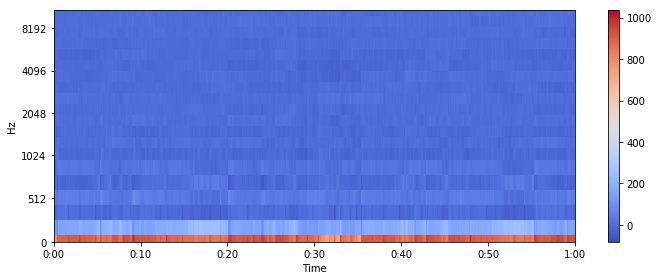

In [42]:
import librosa.display
plt.figure(figsize=(10, 4))
librosa.display.specshow(investigation_mfcc, x_axis='time', y_axis='mel')
plt.colorbar()
plt.tight_layout()
plt.show()

Let's try normalizing.

In [43]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio
a_test = normalize_audio(Train_samples[12][0].astype('float32'))
investigation_mfcc = librosa.feature.mfcc(a_test, Train_samples[102][1])

In [99]:
investigation_mfcc.shape

(20, 2584)

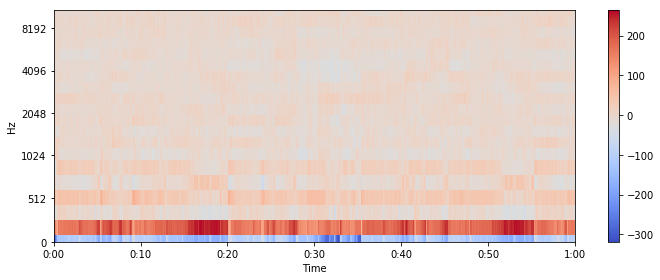

In [100]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(investigation_mfcc, x_axis='time', y_axis='mel')
plt.colorbar()
plt.tight_layout()
plt.show()

Looking at more graphs:

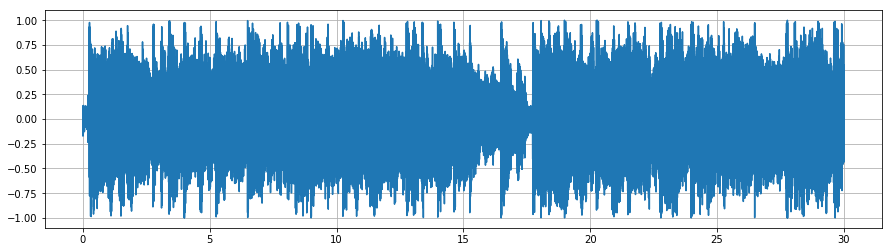

In [101]:
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(a_test) / Train_samples[12][1], num=len(a_test)), a_test)
plt.grid(True)


In [49]:
sd.play(a_test, Train_samples[192][1])

In [50]:
sd.stop()

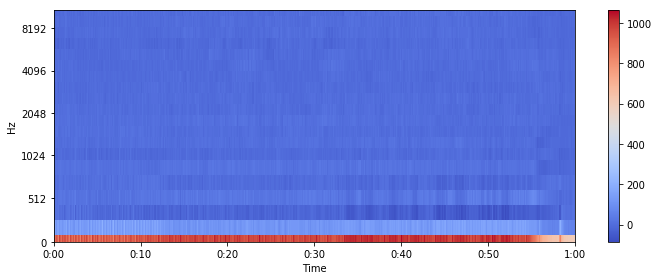

In [103]:
#testing:
investigation_mfcc2 = librosa.feature.mfcc(Train_samples[192][0].astype('float32'), Train_samples[192][1])

plt.figure(figsize=(10, 4))
librosa.display.specshow(investigation_mfcc2, x_axis='time', y_axis='mel')
plt.colorbar()
plt.tight_layout()
plt.show()

In [111]:
investigation_mfcc2.shape

(20, 2584)

One thing to try next is updating the way features are extracted:

In [117]:
def extract_features_song(val):
    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(val[0].astype('float32'), val[i])
    # normalize values between -1,1 (divide by max)
    mfcc /= np.amax(np.absolute(mfcc))

    return np.ndarray.flatten(mfcc)[:25000]


In [112]:
Train_samples_features =\
[[librosa.feature.mfcc(i[0].astype('float32'), sr=i[1]), i[2]]
                         for i in Train_samples]

Let's delete the full songs from memory to clear up some memory for a model.

In [53]:
del(Train_songs)

In [113]:
Train_samples_features[0][0].shape

(20, 2584)

Let's better prepare this:

In [114]:
intermed = [i[0].flatten() for i in Train_samples_features]

In [115]:
Train_samples_features_np = np.stack(intermed, 0)

In [116]:
Train_samples_features_np.shape

(200, 51680)

In [92]:
intermed_y = [i[1] for i in Train_samples_features]

In [93]:
from sklearn.preprocessing import OneHotEncoder

In [94]:
ohc = OneHotEncoder(sparse=False)
y_labels = ohc.fit_transform(np.array(intermed_y).reshape(-1,1))

### Modeling!

This version is simple and will flatten the mfcc features - a better version will use a CNN or RNN with them later.

In [118]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical


Let's make a really simple model:

In [124]:
model = Sequential([
    Dense(100, input_dim=np.shape(Train_samples_features_np)[1]),
    Activation('relu'),
    Dense(2),
    Activation('sigmoid'),
    ])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100)               5168100   
_________________________________________________________________
activation_11 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
_________________________________________________________________
activation_12 (Activation)   (None, 2)                 0         
Total params: 5,168,302
Trainable params: 5,168,302
Non-trainable params: 0
_________________________________________________________________
None


In [125]:
model.fit(Train_samples_features_np, y_labels, epochs=30, batch_size=64,
          validation_split=0.2, verbose=2, shuffle=True)

#loss, acc = model.evaluate(test_input, test_labels, batch_size=32)

#print("Done!")
#print("Loss: %.4f, accuracy: %.4f" % (loss, acc))

Train on 160 samples, validate on 40 samples
Epoch 1/30
 - 0s - loss: 1420.0721 - accuracy: 0.5500 - val_loss: 2796.0989 - val_accuracy: 0.5500
Epoch 2/30
 - 0s - loss: 1557.2937 - accuracy: 0.5469 - val_loss: 315.7364 - val_accuracy: 0.6500
Epoch 3/30
 - 0s - loss: 400.6289 - accuracy: 0.7406 - val_loss: 466.3524 - val_accuracy: 0.6875
Epoch 4/30
 - 0s - loss: 312.4995 - accuracy: 0.7625 - val_loss: 481.4660 - val_accuracy: 0.5875
Epoch 5/30
 - 0s - loss: 144.3512 - accuracy: 0.7937 - val_loss: 166.0053 - val_accuracy: 0.7625
Epoch 6/30
 - 0s - loss: 143.7406 - accuracy: 0.8500 - val_loss: 133.2467 - val_accuracy: 0.7500
Epoch 7/30
 - 0s - loss: 80.6107 - accuracy: 0.8656 - val_loss: 51.1795 - val_accuracy: 0.8875
Epoch 8/30
 - 0s - loss: 37.6696 - accuracy: 0.9594 - val_loss: 11.7020 - val_accuracy: 0.9375
Epoch 9/30
 - 0s - loss: 44.6875 - accuracy: 0.9406 - val_loss: 34.1898 - val_accuracy: 0.9125
Epoch 10/30
 - 0s - loss: 26.1631 - accuracy: 0.9312 - val_loss: 54.8489 - val_accura

Okay, it gets up to 90%.  Next steps:

- trying this on test
- making waaay more samples so this can get better
- updating the mfcc to be smaller and normalized

And of course, later on, trying more appropriate models.